## Natural Language Question Answering
#Anna Bethke, Andy Keller
#Originally Presented at Intel AI DevCon 2018

This notebook gives an overview of an End-to-End Memory Network for goal oriented dialogue, implemented in ngraph.

Goal oriented dialogue is a subset of open-domain dialogue where an automated agent has a specific goal for the outcome of the interaction. At a high level, the system needs to understand a user request and complete a related task with a clear goal within a limited number of dialog turns. This task could be making a restaurant reservation, placing an order, setting a timer, or many of the digital personal assistant tasks.

End-to-End Memory Networks are generic semi-recurrent neural networks which allow for a bank of external memories to be read from and used during execution. They can be used in place of traditional slot-filling algorithms to accomplish goal oriented dialogue tasks without the need for expensive hand-labeled dialogue data. End-to-End Memory Networks have also been shown to be useful for Question-Answering and information retrieval tasks.

This demonstration will go through a short training cycle to conduct full dialogues, and an interactive demonstration of what the network can do with a fully trained model. Training a full model generally does not take a significant amount of time, but it may be longer than the duration of this session. The implementation is based off the paper by A. Bordes, Y. Boureau, J. Weston. Learning End-to-End Goal-Oriented Dialog 2016 and the Github repository chatbot-MemN2N-tensorflow

The model was trained and evaluated on the 6 bAbI Dialog tasks with the following results.

The model was trained and evaluated on the 6 bAbI Dialog tasks with the following results.

| Task | This  | Published |  This (w/ match-type) | Published (w/ match-type)|
|------|--------|-----------| ---------------------|--------------------------|
| 1    | 99.8   | 99.9      | 100.0                | 100.0                    |
| 2    | 100.0  | 100.0     | 100.0                | 98.3                     |
| 3    | 74.8   | 74.9      | 74.6                 | 74.9                     |
| 4    | 57.2   | 59.5      | 100.0                | 100.0                    |
| 5    | 96.4   | 96.1      | 95.6                 | 93.4                     |
| 6    | 48.1   | 41.1      | 45.4                 | 41.0                     |

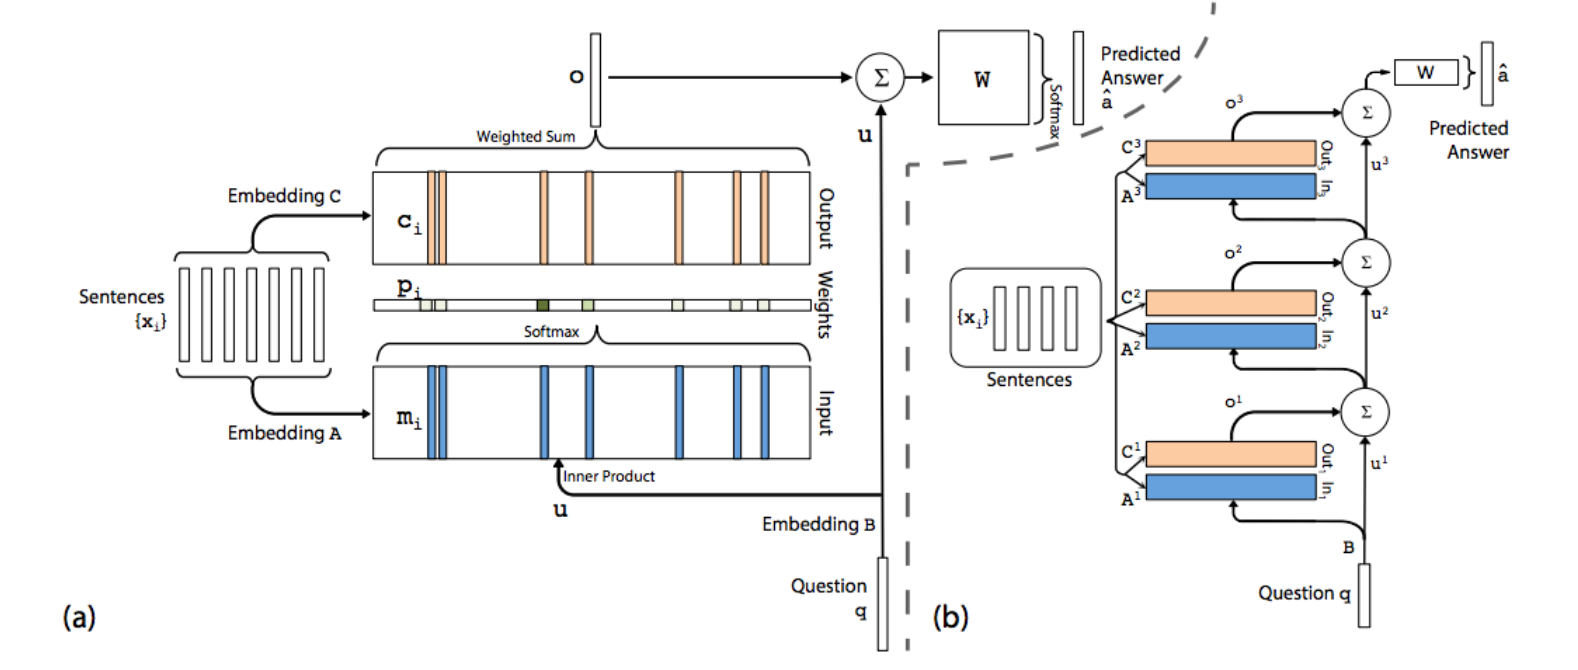

![](https://i.imgur.com/5pQJqjM.png)

Our first step is to import our necessary libraries. For simplicities sake, in this tutorial, we will be using some code from the NLP Architect github reposiotry. The code presented in this demonstration notebook is also included in that repository.

NLP Architect is a repository for models exploring the state of the art deep learning techniques for natural language processing and natural language understanding. It is intended to be a platform for future research and collaboration.

The library includes our past and ongoing NLP research efforts as part of Intel AI Lab. For more information on the library please see the documentation at http://nlp_architect.nervanasys.com, or the github repository at https://github.com/NervanaSystems/nlp-architect.

In [1]:
!export OMP_NUM_THREADS=16 
!export KMP_AFFINITY=granularity=fine,compact,1,0

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [3]:
import os

import numpy as np
import ngraph_bridge
import tensorflow as tf
from interactive_utils import interactive_loop
from tqdm import tqdm

TensorFlow version installed: 1.12.0 (v1.12.0-0-ga6d8ffae09)
nGraph bridge built with: 1.12.0 (v1.12.0-0-ga6d8ffa)


In [4]:
print('TensorFlow version: r',tf.__version__);
#print(ngraph_bridge.__version__)

TensorFlow version: r 1.12.0


In [5]:
from nlp_architect.data.babi_dialog import BABI_Dialog
from nlp_architect.models.memn2n_dialogue import MemN2N_Dialog
from nlp_architect.utils.io import validate_parent_exists, validate


### Setting up arguments and getting the data

To start with, we will set some of the parameters we will need throughout this demonstration. Feel free to change these around. The most important thing to remember though is that when you want to run the interactive demo, you need to have the same parameters that you used when you saved a particular model. 

In [6]:
task = 5 # The task ID to train/test on from bAbI-dialog dataset (1-6)
emb_size = 20 # Size of the word-embedding used in the model.
batch_size = 32 # Size of the batch during training
nhops = 3 # Number of memory hops in the network
use_match_type = False # Use match type features
cache_match_type = False # Cache pre-processed match type answers
cache_vectorized = True # Cache preprocessed/vectorized dataset
use_oov = False # Use OOV test set and for the interactive mode, allow out of vocabulary words
lr = 0.001 # learning rate
gradient_clip_norm = 40.0 # Clip gradients such that norm is below this value
eps = 1e-8 # Epsilon used to avoid divide by zero in softmax renormalization
save_log=True
data_dir = './data/' # The directory of the dataset
log_file = './memn2n_dialgoue_results.txt'
weights_save_path = './saved_tf/'  #File to save model weights to.
save_epochs=10  #Number of epochs between saving model weights, default is 10
epochs=100 # default is 100

#model_file = './memn2n_task5_weights_retrain.npz' # Where you want to store your model weights

restore = False # Restore model weights if found
interactive=True  #enable interactive mode at the end of training
test=True #evaluate on the test set at the end of training


In [7]:
validate_parent_exists(log_file)
validate_parent_exists(weights_save_path)
validate_parent_exists(data_dir)
assert log_file.endswith('.txt')

In [8]:
# Validate inputs
validate((task, int, 1, 7),
         (nhops, int, 1, 10),
         (batch_size, int, 1, 32000),
         (emb_size, int, 1, 10000),
         (eps, float, 1e-15, 1e-2),
         (lr, float, 1e-8, 10),
         (gradient_clip_norm, float, 1e-3, 1e5),
         (epochs, int, 1, 1e10),
         (save_epochs, int, 1, 1e10))

Before we dive into the memory network code, lets get to know our data a little bit better. The dataset used for training and evaluation is under the umbrella of the Facebook bAbI dialog tasks
(https://research.fb.com/downloads/babi/). The terms and conditions of the data set license apply. Intel does not grant any rights to the data files. The dataset is automatically downloaded if not found,
and the preprocessing all happens at the beginning of training.

There are six separate tasks, tasks 1 through 5 are from simulated conversations between a customer
and a restaurant booking bot (created by Facebook), and task 6 is more realistic natural language
restaurant booking conversations as part of the `dialog state tracking challenge`.

The descriptions of the six tasks are as follow:

- bAbI dialog dataset:
    - Task 1: Issuing API Calls
    - Task 2: Updating API Calls
    - Task 3: Displaying Options
    - Task 4: Providing Extra Information
    - Task 5: Conducting Full Dialogs

- Dialog State Tracking Challenge 2 Dataset:
    - Task 6: DSTC2 Full Dialogs
    
We have written a function BABI_Dialog which is able to take a directory of the dataset and with a few parameters prepare the data for the memory network task. Lets look to see what our data looks like before and after it goes through the this class. 

The core of the dataset is conversations, for example the first conversation for Task 5 (our focus today) is:

```
1 good morning	hello what can i help you with today
2 i'd like to book a table with italian food	i'm on it
3 <SILENCE>	where should it be
4 in paris	how many people would be in your party
5 for six people please	which price range are looking for
6 in a cheap price range please	ok let me look into some options for you
7 <SILENCE>	api_call italian paris six cheap
8 actually i would prefer for two people	sure is there anything else to update
9 instead could it be in madrid	sure is there anything else to update
10 instead could it be with spanish food	sure is there anything else to update
11 no	ok let me look into some options for you
12 <SILENCE>	api_call spanish madrid two cheap
13 resto_madrid_cheap_spanish_1stars R_phone resto_madrid_cheap_spanish_1stars_phone
14 resto_madrid_cheap_spanish_1stars R_cuisine spanish
15 resto_madrid_cheap_spanish_1stars R_address resto_madrid_cheap_spanish_1stars_address
16 resto_madrid_cheap_spanish_1stars R_location madrid
17 resto_madrid_cheap_spanish_1stars R_number two
18 resto_madrid_cheap_spanish_1stars R_price cheap
19 resto_madrid_cheap_spanish_1stars R_rating 1
20 resto_madrid_cheap_spanish_6stars R_phone resto_madrid_cheap_spanish_6stars_phone
21 resto_madrid_cheap_spanish_6stars R_cuisine spanish
22 resto_madrid_cheap_spanish_6stars R_address resto_madrid_cheap_spanish_6stars_address
23 resto_madrid_cheap_spanish_6stars R_location madrid
24 resto_madrid_cheap_spanish_6stars R_number two
25 resto_madrid_cheap_spanish_6stars R_price cheap
26 resto_madrid_cheap_spanish_6stars R_rating 6
27 resto_madrid_cheap_spanish_8stars R_phone resto_madrid_cheap_spanish_8stars_phone
28 resto_madrid_cheap_spanish_8stars R_cuisine spanish
29 resto_madrid_cheap_spanish_8stars R_address resto_madrid_cheap_spanish_8stars_address
30 resto_madrid_cheap_spanish_8stars R_location madrid
31 resto_madrid_cheap_spanish_8stars R_number two
32 resto_madrid_cheap_spanish_8stars R_price cheap
33 resto_madrid_cheap_spanish_8stars R_rating 8
34 <SILENCE>	what do you think of this option: resto_madrid_cheap_spanish_8stars
35 no this does not work for me	sure let me find an other option for you
36 <SILENCE>	what do you think of this option: resto_madrid_cheap_spanish_6stars
37 do you have something else	sure let me find an other option for you
38 <SILENCE>	what do you think of this option: resto_madrid_cheap_spanish_1stars
39 it's perfect	great let me do the reservation
40 may i have the phone number of the restaurant	here it is resto_madrid_cheap_spanish_1stars_phone
41 thanks	is there anything i can help you with
42 no thank you	you're welcome
```

It is a mixture of conversation between the user and agent along with API calls, and the resulting database responses, from the agent.

In [ ]:
# Now lets process the data
# This involves parsing the above into user/bot utterances
# Then encoding each word using an integer index into our vocabulary.
# This does take some time (5-10 minutes)
babi = BABI_Dialog(
    path=data_dir,
    task=task,
    oov=use_oov,
    use_match_type=use_match_type,
    cache_match_type=cache_match_type)

Parsing:  61%|██████▏   | 26387/42965 [00:00<00:00, 163430.69it/s]

Preparing bAbI-dialog dataset. Looking in ././data/
Task is dialog-babi-task5-full-dialogs-


Vectorizing:  11%|█         | 2021/18398 [00:08<01:26, 188.28it/s]

The data within the babi object is a dictionary broken up by train/test

If we look at the training data there are answers, utterances, a memory mask and the memory. Each of the data objects has axes information along with the actual data. The data has been preprocessed to be a bag of words representation. The data is already fairly clean in that everything is already lowercase and there are no spelling or gramatical errors.

In [ ]:
babi.data_dict['train'].keys()

In [ ]:
babi.data_dict['train']['user_utt']

In [ ]:
# So for example the second sentence "i'd like to book a table with italian food"  looks like:
babi.data_dict['train']['user_utt']['data'][1]

In [ ]:
# The memory contains information from of the conversation thus far
# so after one back and forth with the agent, it looks like the following:
babi.data_dict['train']['memory']['data'][1]

We can see that all utterances are padded to the maximum sentence length with 0's, and the empty memory slots are also filled with all 0 sentences. These values are eplicitly forced to zero in our embedding layer, and never updated.

In [ ]:
babi.data_dict['train']['memory_mask']['data'][1]


The 'memory_mask' is used to mask out empty memory slots after the softmax is applied during the computation of the scalar similarity values. This is a trick to ensure model correctness, and emulate a softmax over a dynamic memory size.

In [ ]:
train_set = babi.data_dict['train']
dev_set = babi.data_dict['dev']
test_set = babi.data_dict['test']

n_train = train_set['memory']['data'].shape[0]
n_val = dev_set['memory']['data'].shape[0]
n_test = test_set['memory']['data'].shape[0]

In [ ]:
train_batches = zip(range(0, n_train - batch_size, batch_size),
                    range(batch_size, n_train, batch_size))


In [ ]:
train_batches = [(start, end) for start, end in train_batches]

val_batches = zip(range(0, n_val - batch_size, batch_size),
                  range(batch_size, n_val, batch_size))
val_batches = [(start, end) for start, end in val_batches]

test_batches = zip(range(0, n_test - batch_size, batch_size),
                   range(batch_size, n_test, batch_size))
test_batches = [(start, end) for start, end in test_batches]

### Setting up for training

Now that we have the data, lets look at the model we will use to train it

The memory network heavily uses lookup tables - these are mappings from one object space to another. They are being used to map our vocab-size one-hot vectors to embedding-size dense vectors, allowing the model to decrease the input dimensionality and additionally learn how words are associated with each other. 

The class MemN2N_Dialog is the core of the memory network model. It starts with the various arguments that we will pass in when training is initialized.

In [ ]:
with tf.Session() as sess:
    memn2n = MemN2N_Dialog(
        batch_size,
        babi.vocab_size,
        babi.max_utt_len,
        babi.memory_size,
        emb_size,
        babi.num_cands,
        babi.max_cand_len,
        hops=nhops,
        max_grad_norm=gradient_clip_norm,
        optimizer=tf.train.AdamOptimizer(learning_rate=lr, epsilon=eps),
        session=sess)
    
    
    if restore and os.path.exists(weights_save_path):
        print("Loading weights from {}".format(weights_save_path))
        memn2n.saver.restore(sess, weights_save_path)
    elif restore and os.path.exists(weights_save_path) is False:
        print("Could not find weights at {}. ".format(weights_save_path)
              + "Running with random initialization.")

    
    for e in range(epochs):
        np.random.shuffle(train_batches)
        train_cost = []

        for start, end in tqdm(train_batches, total=len(train_batches),
                               unit='minibatches', desc="Epoch {}".format(e)):
            s = train_set['memory']['data'][start:end]
            q = train_set['user_utt']['data'][start:end]
            a = train_set['answer']['data'][start:end]

            if not use_match_type:
                c = np.tile(np.expand_dims(babi.cands, 0), [batch_size, 1, 1])
            else:
                c = train_set['cands_mat']['data'][start:end]

            cost = memn2n.batch_fit(s, q, a, c)
            train_cost.append(cost)

        train_cost_str = "Epoch {}: train_cost {}".format(e, np.mean(train_cost))
        print(train_cost_str)
        
        if save_log:
            with open(log_file, 'a') as f:
                f.write(train_cost_str + '\n')

        if e % save_epochs == 0:
            print("Saving model to {}".format(weights_save_path))
            memn2n.saver.save(sess, weights_save_path)
            print("Saving complete")

            val_error = []
            # Eval after each epoch
            for start, end in tqdm(val_batches, total=len(val_batches),
                                   unit='minibatches', desc="Epoch {}".format(e)):
                s = dev_set['memory']['data'][start:end]
                q = dev_set['user_utt']['data'][start:end]
                a = dev_set['answer']['data'][start:end]

                if not use_match_type:
                    c = np.tile(np.expand_dims(babi.cands, 0), [batch_size, 1, 1])
                else:
                    c = dev_set['cands_mat']['data'][start:end]

                a_pred = memn2n.predict(s, q, c)

                error = np.mean(a.argmax(axis=1) != a_pred)
                val_error.append(error)

            val_err_str = "Epoch {}: Validation Error: {}".format(e, np.mean(val_error))
            print(val_err_str)
            if save_log:
                with open(log_file, 'a') as f:
                    f.write(val_err_str + '\n')

    print('Training Complete.')
    print("Saving model to {}".format(weights_save_path))
    memn2n.saver.save(sess, weights_save_path)
    print("Saving complete")

    if interactive:
        interactive_loop(memn2n, babi)

    if test:
        # Final evaluation on test set
        test_error = []
        # Eval after each epoch
        for start, end in tqdm(test_batches, total=len(test_batches),
                               unit='minibatches'):
            s = test_set['memory']['data'][start:end]
            q = test_set['user_utt']['data'][start:end]
            a = test_set['answer']['data'][start:end]

            if not use_match_type:
                c = np.tile(np.expand_dims(babi.cands, 0), [batch_size, 1, 1])
            else:
                c = test_set['cands_mat']['data'][start:end]

            a_pred = memn2n.predict(s, q, c)

            error = np.mean(a.argmax(axis=1) != a_pred)
            test_error.append(error)

        test_err_str = "Test Error: {}".format(np.mean(test_error))
        print(test_err_str)
        if save_log:
            with open(log_file, 'a') as f:
                f.write(test_err_str + '\n')

